In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as ex
from evaluation import *
from sk_models import CustomWrapper
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from tqdm.notebook import tqdm, trange
from sk_models import PLSRegression
seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and outpu t formats, load data

file_name = "A_C_OF_SIWARE.csv" # "PLN7.csv"
id_cols = []#["sample_id"]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/1.01") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\1.01\A_C_OF_SIWARE


In [3]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)
n_features = ncol - 1-len(id_cols)
dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)
eval = CrossValEvaluation(preprocessing=None,tensorboard=None,time=True,random_state=random_state)
print(f"Dataset shape is {data.shape}")

Dataset shape is (13916, 247)


In [4]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="log",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="test_log",file_name=log_dir/"test_log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
tb = SummaryWriter(log_dir/"tb")
summary_logger = logging.getLogger("summary")
#step 1, run pls, set up pls - that runs best
n_comps = [i for i in range(1,101)]
pls_models = {i:PLSRegression(n_components=i) for i in n_comps}

pls_scheme = SKLearnScheme(logger="log")
scores_pls, preds_pls, model_states_pls , train_time_pls, test_time_pls,_ = eval.evaluate(pls_models,dataset,pls_scheme,logger_name="log")
summary_logger.info(f"Train times: {train_time_pls}")
summary_logger.info(f"Test times: {test_time_pls}")
from collections import defaultdict
summary_logger.info(f"Scores: {scores_pls}")
for key,value in flip_dicts(scores_pls).items():
    summary_logger.info(f"{key}: {value}")

selected_comps =  min(scores_pls["MSE"],key=scores_pls["MSE"].get)
summary_logger.info(f"Selected pls preprocessing with {selected_comps} components")

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training SKLearn with a train loss of 1:303.3696,2:297.698,3:268.5639,4:228.6555,5:221.7038,6:203.9539,7:201.006,8:197.5122,9:195.7092,10:193.1037,11:189.55,12:188.3762,13:185.5406,14:184.8236,15:183.7554,16:182.9346,17:182.4316,18:181.8299,19:181.5873,20:181.364,21:181.0507,22:180.8183,23:180.5975,24:180.4706,25:180.3172,26:180.2479,27:180.0848,28:179.929,29:179.7862,30:179.6789,31:179.5678,32:179.4196,33:179.3174,34:179.1482,35:179.0141,36:178.8126,37:178.6545,38:178.4367,39:178.257,40:178.0996,41:177.9869,42:177.7648,43:177.6419,44:177.5362,45:177.3944,46:177.2747,47:177.157,48:176.984,49:176.8333,50:176.6422,51:176.5596,52:176.4384,53:176.3011,54:176.1157,55:175.9549,56:175.8083,57:175.7221,58:175.6319,59:175.5258,60:175.3723,61:175.2605,62:175.1153,63:174.9779,64:174.8611,65:174.7812,66:174.7251,67:174.6276,68:174.562,69:

In [5]:
eval = CrossValEvaluation(preprocessing=PLSRegression(n_components=selected_comps),tensorboard=None,time=True,random_state=random_state)

### Training the deep learners
The following cells setup our models and run a train-test evaluation.

In [ ]:
n_models = 100
epochs = 100
bs = 32
fixed_hyperparams = {'bs': bs,'loss': nn.MSELoss(),'epochs': epochs}
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#setup models
config_gen = RandomConfigGen(lr= (0,1),
                             allow_increase_size=False,
                             n_features=selected_comps,
                             opt=[torch.optim.SGD,
                                  torch.optim.Adam],
                             lr_update = [None,
                                          torch.optim.lr_scheduler.ReduceLROnPlateau,
                                          torch.optim.lr_scheduler.ExponentialLR,
                                          torch.optim.lr_scheduler.CosineAnnealingLR],
                            dropout = [True,False],
                            batch_norm = [True,False])
configs = {f"random_{i}":config_gen.sample() for i in range(n_models)}
config_gen.save(log_dir/'config_gen.txt')

deep_models = {name:RandomNet(input_size=selected_comps,
                             n_layers=config.n_layers,
                             act_function=config.act_function,
                             n_features = config.n_features,
                             dropout=config.dropout,
                             batch_norm=config.batch_norm,
                             device=device,dtype=torch.float)
              for name, config in configs.items()}

ex.write_summary_head(seed,fixed_hyperparams)
ex.save_models(deep_models,configs,log_dir)
start = datetime.datetime.now()

deep_scheme = DeepScheme(configs,fixed_hyperparams=fixed_hyperparams,logger="log",device=device,adaptive_lr=True)
scores_deep, preds_deep, model_states_deep , train_time_deep, test_time_deep,pp_state = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log")

In [7]:
scores_final, preds_final, model_states_ls_final , train_time_deep_final, test_time_deep_final,pp_state_final = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log")

Building final model - Train 9276 - Test 2320'
Training extractors on 9276 instances, validating on 2320 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_0:nan(-0.091585),random_1:nan(-0.606802),random_2:11500.581(-0.901208),random_3:258.7097(-0.891789),random_4:113090264.664(-0.173589),random_5:261.1284(-0.361886),random_6:278490022.4368(-0.279102),random_7:261.1461(-0.567705),random_8:46682.3307(-0.772984),random_9:nan(-0.488906),random_10:nan(-0.058759),random_11:268.6354(-0.244832),random_12:273.2295(-0.360218),random_13:nan(-0.729424),random_14:nan(-0.385566),random_15:557.13(-0.938464),random_16:5001338.9386(-0.551503),random_17:nan(-0.093454),random_18:255.0722(-0.514803),random_19:3.6970488165819147e+21(-0.670561),random_20:243.8207(-0.635076),random_21:492427905821.0504(-0.080429),random_22:nan(-0.151115),random_23:nan(-0.099773),random_24:74311728.4893(-0.309726),random_25:289.1595(-0.511501),random_26:37509448.754(-0.366184),random_27:nan(-0.8743

In [8]:
for model, state_dict in model_states_ls_final.items():
     torch.save(state_dict.state(), log_dir / "models" / f"{model}" / f"_final")
        

ex.save_pp(pp_state,log_dir)
PLSRegression(n_components=selected_comps).save_state(pp_state_final.state(),log_dir / "preprocessing"   / f"_final")
        
summary_logger.info(f"Train times: {train_time_deep}")
summary_logger.info(f"Test times: {test_time_deep}")
ex.save_results(model_states_deep, preds_deep, configs, scores_deep, log_dir,tb)


end = datetime.datetime.now()
diff = end - start
ex.write_summary(diff, deep_models, scores_deep)
ex.save_pred_plots(preds_deep, deep_models, log_dir)



Train times: {'fold_0': 5440, 'fold_1': 5113, 'fold_2': 4955, 'fold_3': 4687, 'fold_4': 4979, 'mean': 5034.8}'
Test times: {'fold_0': 4, 'fold_1': 4, 'fold_2': 4, 'fold_3': 4, 'fold_4': 4, 'mean': 4.0}'
Experiments took 9:21:52.722904'
Finished Random Deep Search'
---Loss results---'
0 - random_60 - fold_0:115.4959,fold_1:147.7049,fold_2:91.2359,fold_3:92.3547,fold_4:85.1889,MSE:106.3968,R2:0.6937'
1 - random_54 - fold_0:122.6783,fold_1:141.0993,fold_2:95.2822,fold_3:84.5037,fold_4:97.6628,MSE:108.2465,R2:0.6884'
2 - random_83 - fold_0:112.6084,fold_1:145.1887,fold_2:112.2898,fold_3:98.9586,fold_4:104.6625,MSE:114.7414,R2:0.6697'
3 - random_11 - fold_0:128.632,fold_1:154.0714,fold_2:101.9308,fold_3:90.1242,fold_4:116.1241,MSE:118.1774,R2:0.6598'
4 - random_69 - fold_0:105.7877,fold_1:155.2199,fold_2:112.0024,fold_3:101.7996,fold_4:116.7492,MSE:118.3107,R2:0.6594'
5 - random_5 - fold_0:126.037,fold_1:143.1112,fold_2:111.7265,fold_3:102.5186,fold_4:113.2364,MSE:119.3265,R2:0.6565'
6 - ra

In [9]:
scores_df = pd.DataFrame(scores_deep)
scores_df.to_csv(log_dir / f"scores.csv", index=False)
scores_df_final = pd.DataFrame(scores_final)
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)

### Plotting deep results as a function of number of features

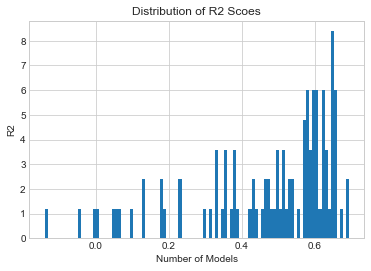

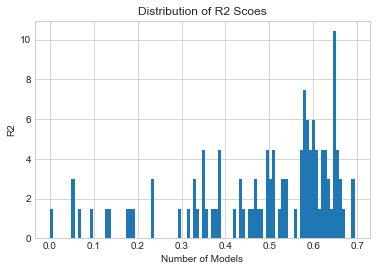

In [10]:
from matplotlib import pyplot as plt
if True:
    # plot deep results as a function of number of features

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["R2"][name],n_features_dict[name]] for name in scores_deep["R2"].keys()]
                           ,columns = ["name","score","n_features"])

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["R2"][name],n_features_dict[name]] for name in scores_deep["R2"].keys()]
                           ,columns = ["name","score","n_features"])
    to_plot = to_plot[to_plot["score"]>=0]

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot_compressed.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')
    pass

    #plot

In [11]:
summary_logger.info("------------------\n Top 5 performance on Test Set")
summary_logger.info(f"Index - Model - Val - Score - Test Score")
for i,key in enumerate(sorted(scores_deep['MSE'],key=scores_deep['MSE'].get)):
    if i <5:
        summary_logger.info(f"{i} - {key} - {scores_deep['MSE'][key]} - {scores_deep['R2'][key]} - {scores_final['MSE'][key]} - {scores_final['R2'][key]}")

------------------
 Top 5 performance on Test Set'
Index - Model - Val - Score - Test Score'
0 - random_60 - 106.39684576148638 - 0.6937172342672797 - 112.66962403605382 - 0.6574766710846802'
1 - random_54 - 108.24650952239685 - 0.6883926390848507 - 102.93540148269693 - 0.6870693704648739'
2 - random_83 - 114.7413996438966 - 0.669695910856624 - 115.46665402169978 - 0.6489735094742994'
3 - random_11 - 118.17740749700282 - 0.6598047342827631 - 107.6531752564184 - 0.6727270169523836'
4 - random_69 - 118.31067885912228 - 0.6594210883100767 - 109.36430219496935 - 0.6675250745459582'


In [12]:
if False:
    model_path = Path('D:/workspace/lazydeep/experiments/1.01/')
    log_path = Path("D:/workspace/lazydeep/experiments/1.02")

    log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
    model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

    if not log_dir.exists():
        log_dir.mkdir()

    ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
    ut.setup_logger(logger_name="summary2",file_name=log_dir/"summary.txt")
    summary_logger = logging.getLogger("summary2")
    tb = SummaryWriter(log_dir/"tb")



    deep_scores_dict={}
    deep_preds_dict={}
    actual_y = None
    preprocessing=PLSRegression(n_components=selected_comps)

    load_fun_cv = lambda name,model, fold : model.load_state(model_dir/'models'/name/f"_fold_{fold}")
    load_fun_pp_cv = lambda fold : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_fold_{fold}"))
    load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
    load_fun_pp_build = lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))

    deep_scheme = DeepScheme(configs, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=False,update=False)
    deep_scores, deep_preds, _ , _, _,_ = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp=load_fun_pp_cv)
    deep_scores_final, deep_preds_final, _ ,_, _,_ = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp=load_fun_pp_build)

In [13]:
if False:
    all_scores = []
    for k,v in ut.flip_dicts(deep_scores).items():
        dict1 = {'model_num':k,"predictor":"deep"}
        all_scores.append({**dict1,**v})

    all_scores_final = []
    for k,v in ut.flip_dicts(deep_scores_final).items():
        dict1 = {'model_num':k,"predictor":"deep"}
        all_scores_final.append({**dict1,**v})  

    scores_df_sorted = pd.DataFrame(all_scores).sort_values(by='MSE')
    for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
        s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
        print(s)

In [14]:
if False:
    model_names = deep_models.keys()
    for name in model_names:
            sub_path = log_dir / name
            if not sub_path.exists():
                sub_path.mkdir()

In [15]:
if False:
    from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression
    from plot import plot_preds_and_res

    for deep_name,deep_model in tqdm(deep_models.items()):
        if int(deep_name.replace("random_",""))>24:
            logging.getLogger().info(f"Running model {deep_name}")
            temp_dict = {deep_name:deep_model}

            lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = setup_pls_models_exh(nrow),n_neighbours=500,loss_fun_sk = mean_squared_error)
            lwr_scores, lwr_preds, _ , _, _,_= eval.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp = load_fun_pp_cv)
            lwr_scores_final, lwr_preds_final, _ , _, _,_= eval.build(temp_dict,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)

            #scores
            for k,v in ut.flip_dicts(lwr_scores).items():
                dict1 = {'model_num':deep_name,"predictor":k}
                all_scores.append({**dict1,**v})

            for k,v in ut.flip_dicts(lwr_scores_final).items():
                dict1 = {'model_num':deep_name,"predictor":k}
                all_scores_final.append({**dict1,**v})

            lwr_preds['deep'] = deep_preds[deep_name]
            lwr_preds_final['deep'] = deep_preds_final[deep_name]

            lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
            lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

            #preds
            # todo save predictions - appending solns
            plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)



In [16]:
if False:
    scores_df = pd.DataFrame(all_scores)
    scores_df.to_csv(log_dir/f"scores.csv",index=False)
    scores_df_final = pd.DataFrame(all_scores_final)
    scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

    scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

    best_5 = []
    summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
    for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
        if i < 5:
            best_5.append((row["model_num"],row["predictor"],row["MSE"]))
        s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
        summary_logger.info(s)

In [17]:
if False:
    summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
    summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
    for i, (j,k,v) in enumerate(best_5):

        row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
        #print(row)
        s = f"{i} - {j} - {k} - {v} - {row['MSE']} - {row['R2']}"
        summary_logger.info(s)


In [18]:
if False:
    scores_df_original =  pd.read_csv(model_path/re.sub(r'\.(?=csv$)[^.]+$', '',file_name)/"scores.csv")
    scores_df_original["model_num"] = [f"random_{i}" for i in range(0,100)]
    print(scores_df_original)

In [19]:
if False:
    #take 1 is a scatter plot - lets, for each dataset
    #graph our deep models by rank - plot - then overlay our knn moels
    #plot points


    deep_set = scores_df_original.sort_values("R2")
    deep_set["order"] = [i for i in range(0,100)]
    deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}
    print(deep_ordering)
    def order_models(x):
        x = [deep_ordering[i] for i in x]
        return x

    fig, ax = plt.subplots()
    set_deep = False
    knn_models = scores_df["predictor"].unique()
    for knn_model in knn_models:
        subset = scores_df[scores_df["predictor"]==knn_model]
        ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=3, label=knn_model)

    ax.scatter(x=order_models(deep_set["model_num"]),y=deep_set["R2"],s=10,label="deep")
    #ax.set_ylim(0,scores_db["deep_mean"].max())
    ax.set_ylim(0,1)
    # plot residuals
    ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_ylabel("R^2 Score")
    ax.set_xlabel("Deep Model Rank")
    #ax.set_ylim(0,200)
    #ax.set_yscale("symlog")
    ax.set_title("Summary of LWR improvements over Deep Models")
    plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')
    logging.getLogger().info("Wrote Summary Graph")

In [20]:
if False:
    scores_df["n_features"] = [deep_models[i].n_features for i in scores_df["model_num"]] 
    from matplotlib.colors import Colormap
    import seaborn as sns #heatmap of features - pls model - score
    class nlcmap(Colormap):
        def __init__(self, cmap, levels):
            self.cmap = cmap
            self.N = cmap.N
            self.monochrome = self.cmap.monochrome
            self.levels = np.asarray(levels, dtype='float64')
            self._x = self.levels
            self.levmax = self.levels.max()
            self.levmin = self.levels.min()
            self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
                 len(self.levels))

        def __call__(self, xi, alpha=1.0, **kw):
            yi = np.interp(xi, self._x, self.transformed_levels)
            return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)

    levels = np.concatenate((
        [0, 1],
        [0.6,0.8,0.9,0.95,0.98]
        ))

    levels = levels[levels <= 1]
    levels.sort()
    cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels)


In [21]:
if False:
    subset = scores_df[["predictor","n_features","R2"]]
    subset = subset[np.logical_not(subset["predictor"]=="deep")]
    subset = subset[np.logical_not(subset["predictor"]=="lr")]
    trans = subset["predictor"].transform(lambda x: int(x.replace("lwr_k=",""))).tolist()
    subset.loc[:,"predictor"]=trans
    subset=subset.sort_values("predictor",ascending=False)

    def rand_jitter(arr):
        stdev = .01 * (max(arr) - min(arr))
        return arr + np.random.randn(len(arr)) * stdev

In [22]:
if False:
    fig, ax = plt.subplots()
    sc = ax.scatter(x=rand_jitter(subset["n_features"]), y=rand_jitter(subset["predictor"]), s=20,c=subset["R2"],cmap=cmap_nonlin,vmin=0)
    ax.set_xlabel("Number of Features")
    ax.set_ylabel("Number of Neighbours")

    cbar = fig.colorbar(sc,label="R2 Score")

    ax.set_title("LWR performance as a function of the number of components")
    plt.savefig(log_dir/f"heat_scatter.png", bbox_inches='tight')